In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Ruta a la carpeta donde están los CSVs
ruta_base = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Crear lista para guardar resultados
resultados = []

# Función para calcular RMS
def rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

# Procesar todos los archivos CSV que empiecen por "raw_data"
for archivo in os.listdir(ruta_base):
    if archivo.startswith("raw_data") and archivo.endswith(".csv"):
        ruta_archivo = os.path.join(ruta_base, archivo)
        
        # Extraer valor de SpO2 real desde el nombre del archivo
        match = re.match(r"raw_data_(\d+)_\d+.*\.csv", archivo)
        if not match:
            continue
        spo2_real = int(match.group(1))

        # Cargar el CSV
        df = pd.read_csv(ruta_archivo)

        # Filtrar datos después de 3000 ms
        df_filtrado = df[df["Tiempo (ms)"] >= 3000]

        # Calcular señales corregidas
        ir_corr = df_filtrado["IR"] - df_filtrado["AMB_IR"]
        red_corr = df_filtrado["RED"] - df_filtrado["AMB_RED"]

        # Calcular RMS
        rms_ir = rms(ir_corr)
        rms_red = rms(red_corr)

        # Calcular ratio
        ratio = rms_red / rms_ir if rms_ir != 0 else np.nan

        # Guardar resultado
        resultados.append({
            "Archivo": archivo,
            "SpO2_real": spo2_real,
            "RMS_IR": rms_ir,
            "RMS_RED": rms_red,
            "Ratio": ratio
        })

# Crear DataFrame con los resultados
tabla_resultados = pd.DataFrame(resultados)

# Mostrar la tabla
pd.set_option('display.precision', 4)
display(tabla_resultados)

# (Opcional) Guardar como Excel para revisión externa
tabla_resultados.to_excel("tabla_ratio_vs_spo2.xlsx", index=False)


,Archivo,SpO2_real,RMS_IR,RMS_RED,Ratio
0,raw_data_91_91.csv,91,32048.4703,54623.4530,1.7044
1,raw_data_92_76.csv,92,32941.8140,4240.6008,0.1287
2,raw_data_93_100.csv,93,26349.9486,28045.7718,1.0644
3,raw_data_95_77_2.csv,95,53323.9320,52501.1351,0.9846
4,raw_data_95_80.csv,95,35845.1214,18706.2565,0.5219
5,raw_data_95_81_papa.csv,95,23099.0289,60610.2657,2.6239
6,raw_data_95_99.csv,95,37621.2901,31481.7316,0.8368
7,raw_data_96_106.csv,96,60488.6076,56226.2411,0.9295
8,raw_data_96_69.csv,96,59828.4682,60354.8221,1.0088
9,raw_data_96_81.csv,96,27989.6489,6840.9635,0.2444


Modelo ajustado: SpO2_estimada = -0.9561 * Ratio + 96.86
Error medio absoluto (MAE): 1.75%


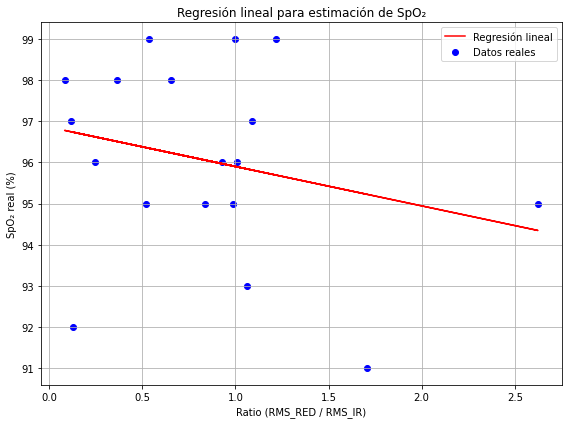

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Eliminar filas con NaN por si alguna RMS dio error
df_modelo = tabla_resultados.dropna(subset=["Ratio", "SpO2_real"])

# Variables
X = df_modelo["Ratio"].values.reshape(-1, 1)
y = df_modelo["SpO2_real"].values

# Ajuste del modelo lineal
modelo = LinearRegression()
modelo.fit(X, y)

# Predicciones
y_pred = modelo.predict(X)

# Coeficientes de la regresión
m = modelo.coef_[0]
b = modelo.intercept_
mae = mean_absolute_error(y, y_pred)

print(f"Modelo ajustado: SpO2_estimada = {m:.4f} * Ratio + {b:.2f}")
print(f"Error medio absoluto (MAE): {mae:.2f}%")

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Datos reales', color='blue')
plt.plot(X, y_pred, color='red', label='Regresión lineal')
plt.xlabel("Ratio (RMS_RED / RMS_IR)")
plt.ylabel("SpO₂ real (%)")
plt.title("Regresión lineal para estimación de SpO₂")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Este resultado es el modelo lineal que relaciona el valor del ratio (RMS_RED / RMS_IR) con la SpO₂ real.

- Ratio: lo calculo con mis señales corregidas.

- -0.9561: es la pendiente. Indica que a medida que el Ratio sube, la SpO₂ estimada baja (como suele ser en pulsioxímetros).

- +96.86: es la ordenada en el origen. Es el valor de SpO₂ estimado si el ratio fuera 0 (que no pasa, pero matemáticamente está ahí).

MAE = 1.75%
Es el Error Medio Absoluto entre los valores reales que extrajiste del nombre del archivo y los valores estimados por la regresión.

Es decir, de media, se equivoca en ±1.75 puntos porcentuales respecto a los valores reales.
En el contexto de SpO₂, un error menor a ±2% es bastante aceptable si no estás haciendo una validación clínica completa.

In [3]:
import os
import pandas as pd
import numpy as np
import re

# Función RMS
def rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

# Modelo de regresión ajustado previamente (basado en tus datos)
def estimar_spo2_por_ratio(ratio):
    return -0.9561 * ratio + 96.86

# Ruta donde están tus CSVs
ruta_base = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Lista para guardar resultados
resultados = []

# Recorrer archivos
for archivo in os.listdir(ruta_base):
    if archivo.startswith("raw_data") and archivo.endswith(".csv"):
        ruta_archivo = os.path.join(ruta_base, archivo)
        
        # Extraer valor de SpO2 real del nombre
        match = re.match(r"raw_data_(\d+)_\d+.*\.csv", archivo)
        if not match:
            continue
        spo2_real = int(match.group(1))

        # Leer el CSV
        df = pd.read_csv(ruta_archivo)

        # Filtrar primeros 3 segundos
        df = df[df["Tiempo (ms)"] >= 3000]

        # Señales corregidas (luz ambiente)
        ir_corr = df["IR"] - df["AMB_IR"]
        red_corr = df["RED"] - df["AMB_RED"]

        # Calcular RMS
        rms_ir = rms(ir_corr)
        rms_red = rms(red_corr)

        # Calcular Ratio
        if rms_ir == 0:
            ratio = np.nan
            spo2_estimado = np.nan
        else:
            ratio = rms_red / rms_ir
            spo2_estimado = estimar_spo2_por_ratio(ratio)

        # Guardar resultados
        resultados.append({
            "Archivo": archivo,
            "SpO2_real": spo2_real,
            "RMS_IR": rms_ir,
            "RMS_RED": rms_red,
            "Ratio": ratio,
            "SpO2_estimado": spo2_estimado,
            "Error (%)": spo2_estimado - spo2_real if not np.isnan(spo2_estimado) else np.nan
        })

# Mostrar resultados como tabla
tabla_resultados = pd.DataFrame(resultados)
pd.set_option('display.precision', 2)
display(tabla_resultados)

# Guardar en Excel si quieres
tabla_resultados.to_excel("SpO2_estimada_con_regresion.xlsx", index=False)


,Archivo,SpO2_real,RMS_IR,RMS_RED,Ratio,SpO2_estimado,Error (%)
0,raw_data_91_91.csv,91,32048.47,54623.45,1.70,95.23,4.23
1,raw_data_92_76.csv,92,32941.81,4240.60,0.13,96.74,4.74
2,raw_data_93_100.csv,93,26349.95,28045.77,1.06,95.84,2.84
3,raw_data_95_77_2.csv,95,53323.93,52501.14,0.98,95.92,0.92
4,raw_data_95_80.csv,95,35845.12,18706.26,0.52,96.36,1.36
5,raw_data_95_81_papa.csv,95,23099.03,60610.27,2.62,94.35,-0.65
6,raw_data_95_99.csv,95,37621.29,31481.73,0.84,96.06,1.06
7,raw_data_96_106.csv,96,60488.61,56226.24,0.93,95.97,-0.03
8,raw_data_96_69.csv,96,59828.47,60354.82,1.01,95.90,-0.10
9,raw_data_96_81.csv,96,27989.65,6840.96,0.24,96.63,0.63


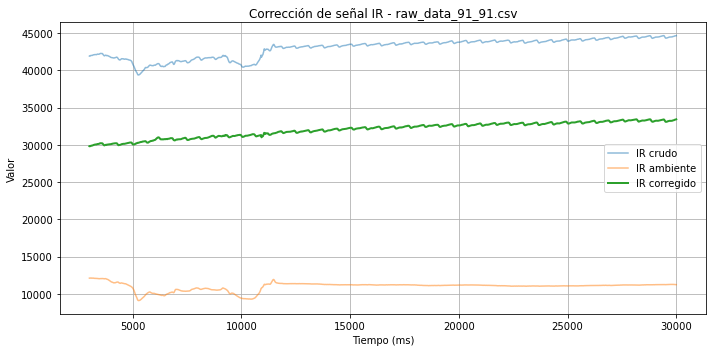

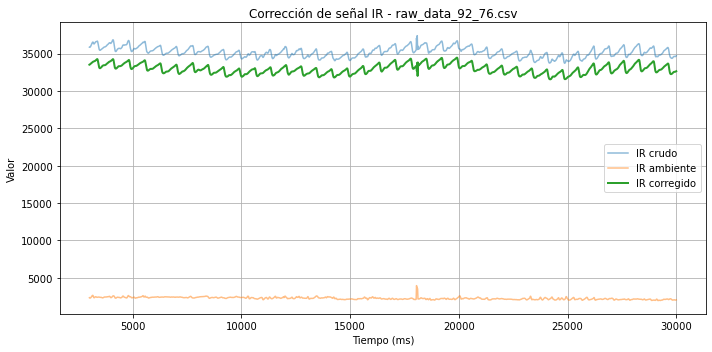

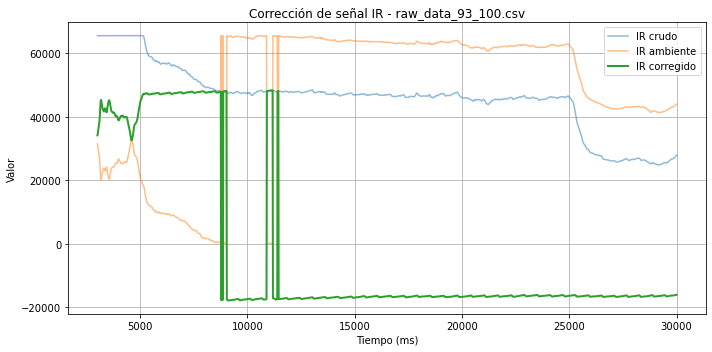

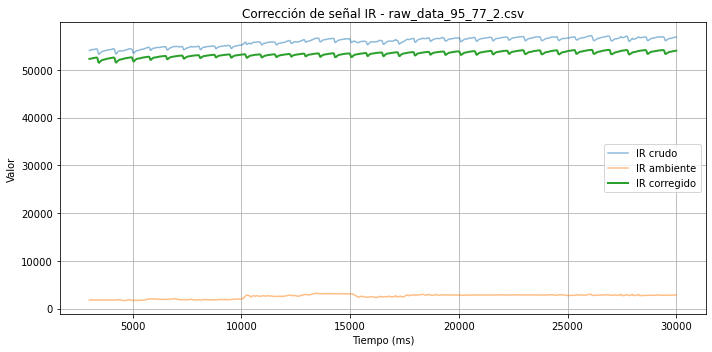

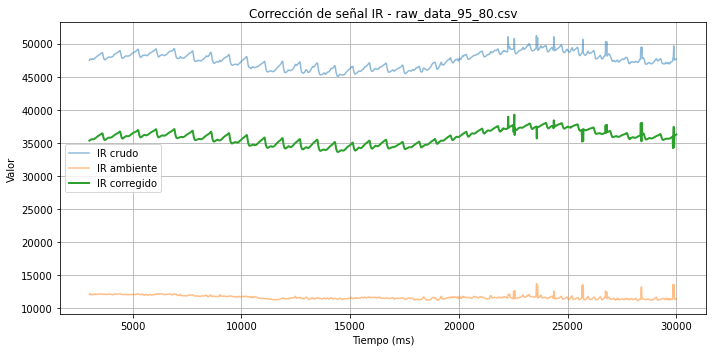

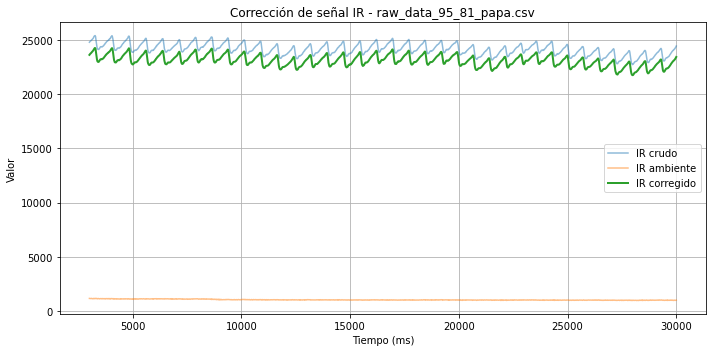

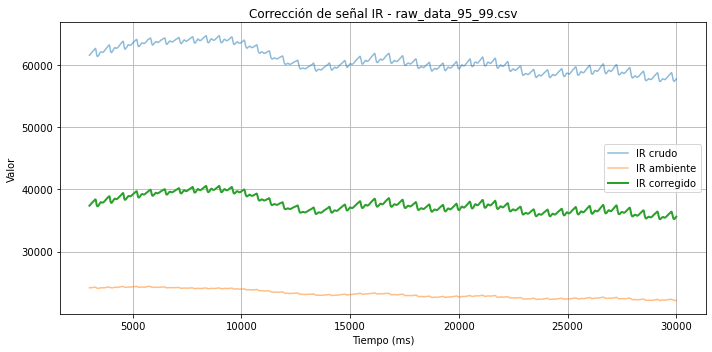

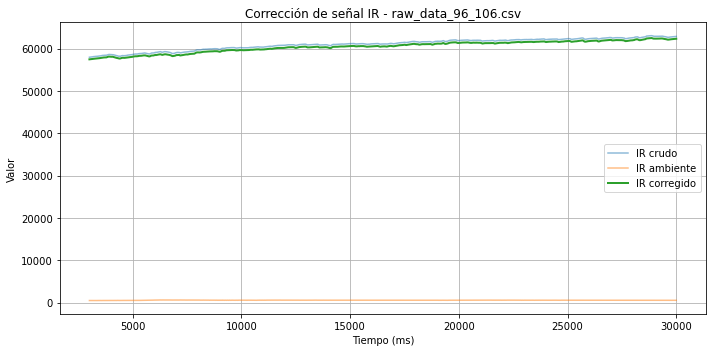

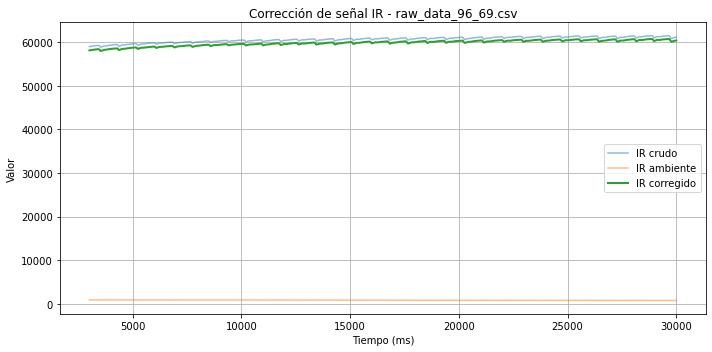

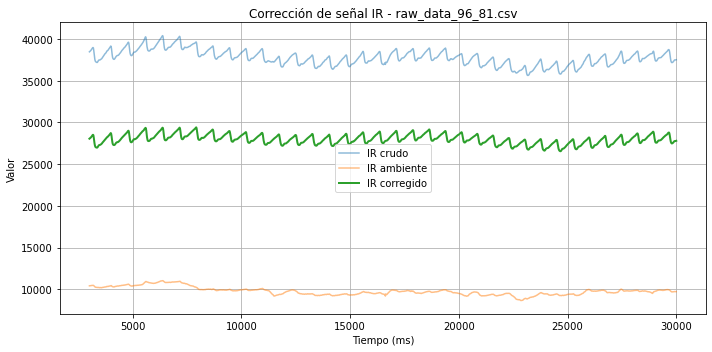

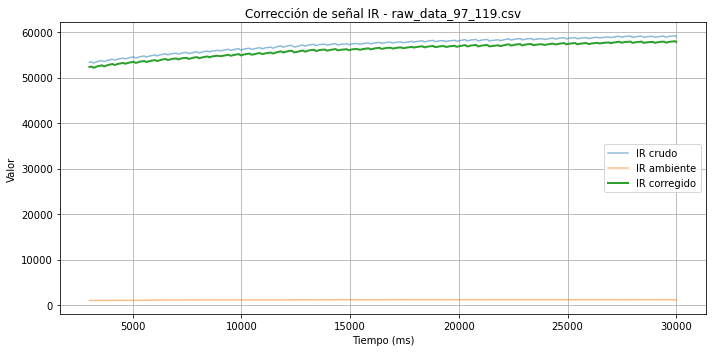

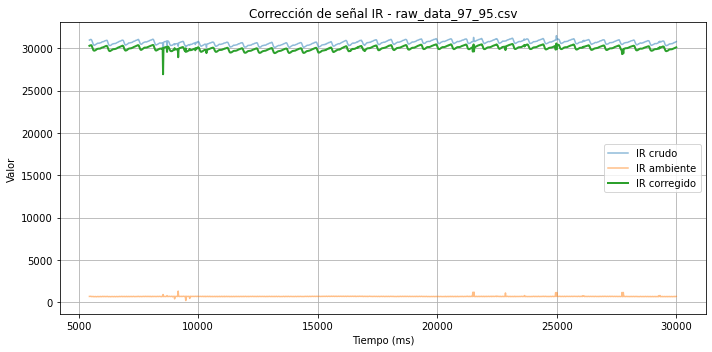

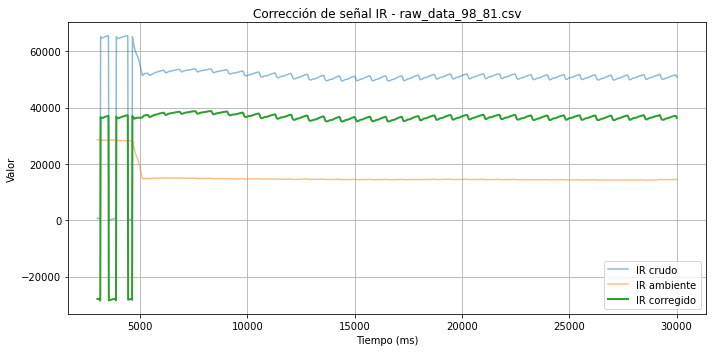

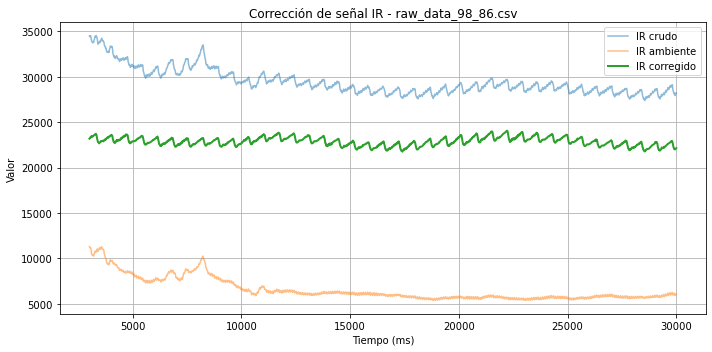

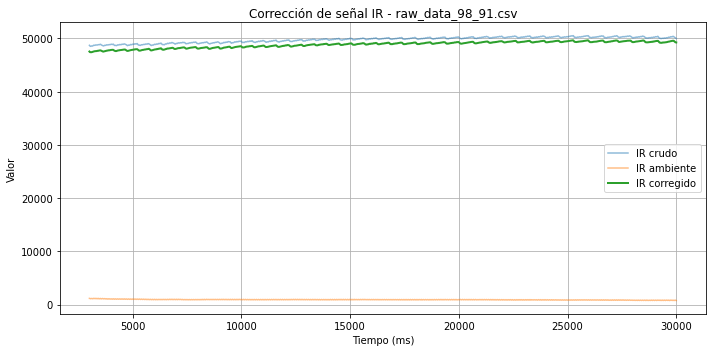

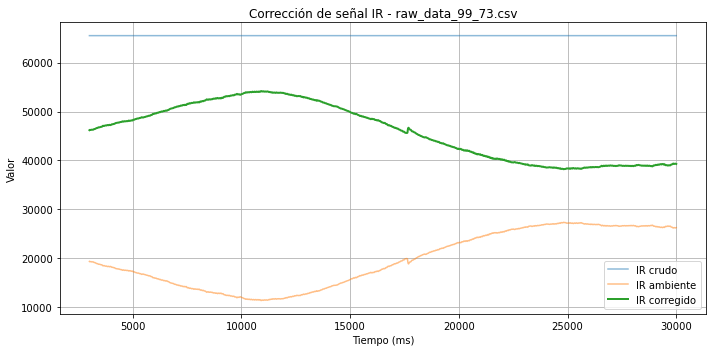

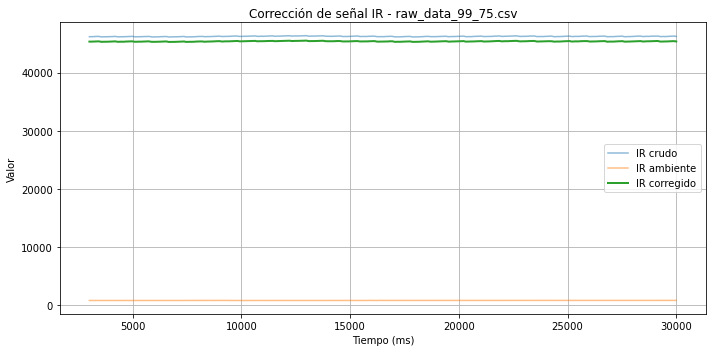

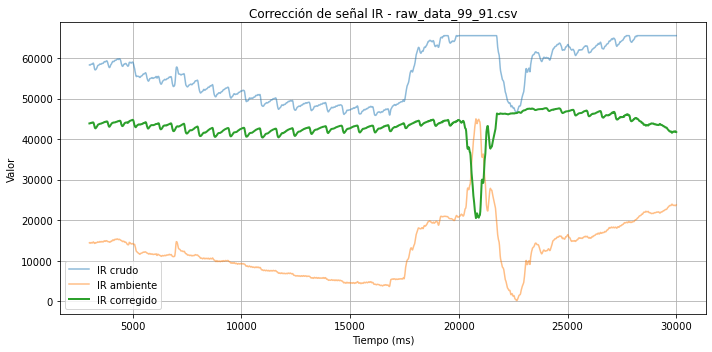

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ruta de los CSVs
ruta_base = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Opcional: carpeta donde guardar los gráficos (crear si no existe)
guardar_png = False
carpeta_salida = os.path.join(ruta_base, "graficas_IR")
if guardar_png and not os.path.exists(carpeta_salida):
    os.makedirs(carpeta_salida)

# Recorrer todos los archivos CSV
for archivo in os.listdir(ruta_base):
    if archivo.endswith(".csv") and archivo.startswith("raw_data"):
        ruta_csv = os.path.join(ruta_base, archivo)
        df = pd.read_csv(ruta_csv)

        # Filtrar primeros 3 segundos
        df_filtrado = df[df["Tiempo (ms)"] >= 3000]

        # Calcular señal IR corregida
        ir_corr = df_filtrado["IR"] - df_filtrado["AMB_IR"]

        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["IR"], label="IR crudo", alpha=0.5)
        plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["AMB_IR"], label="IR ambiente", alpha=0.5)
        plt.plot(df_filtrado["Tiempo (ms)"], ir_corr, label="IR corregido", linewidth=2)
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Valor")
        plt.title(f"Corrección de señal IR - {archivo}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if guardar_png:
            nombre_salida = os.path.splitext(archivo)[0] + "_IR.png"
            plt.savefig(os.path.join(carpeta_salida, nombre_salida))
        else:
            plt.show()

        plt.close()


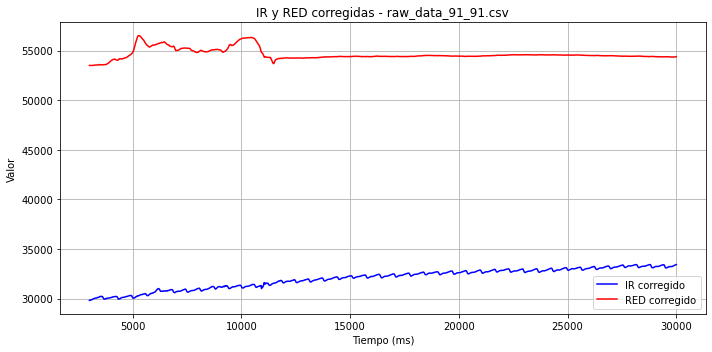

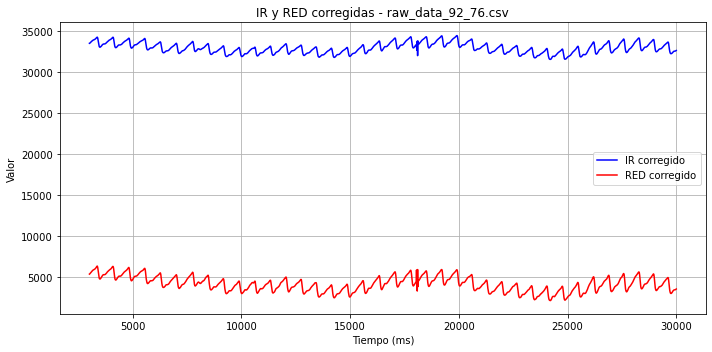

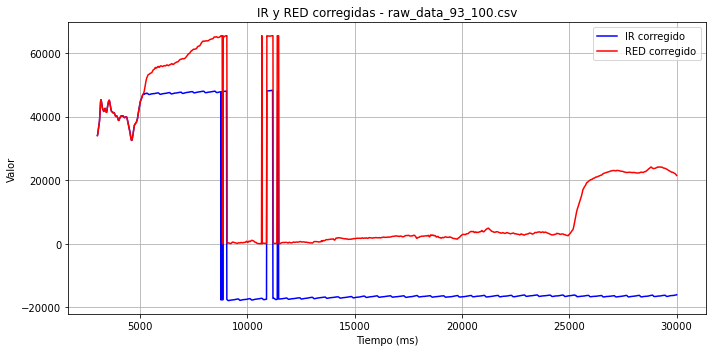

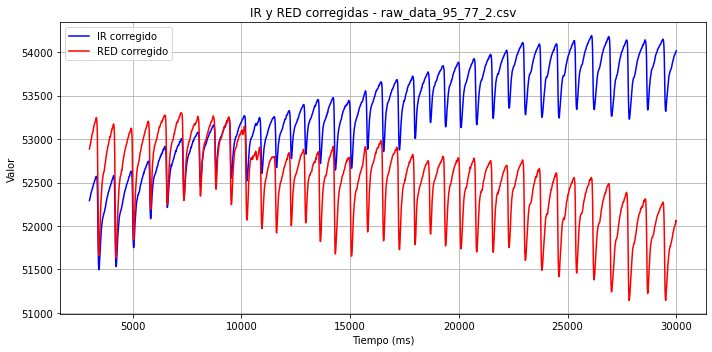

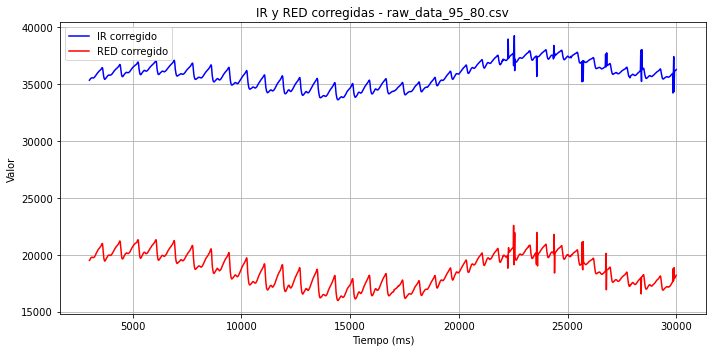

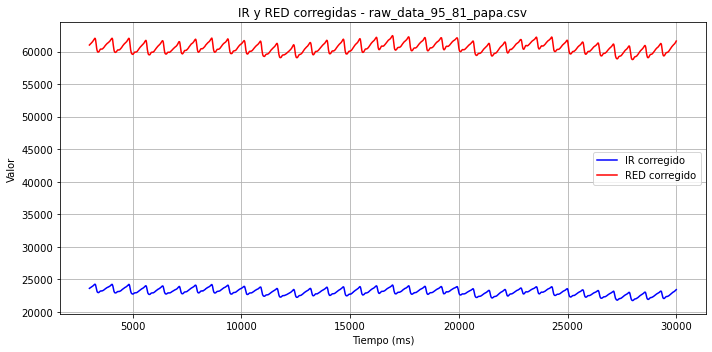

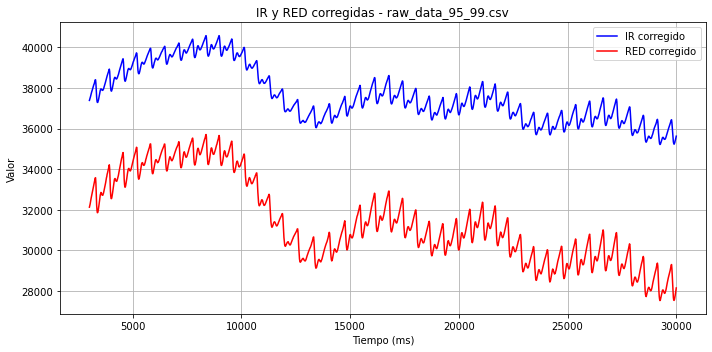

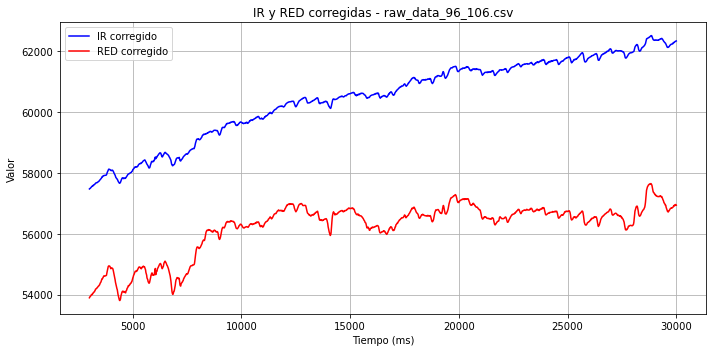

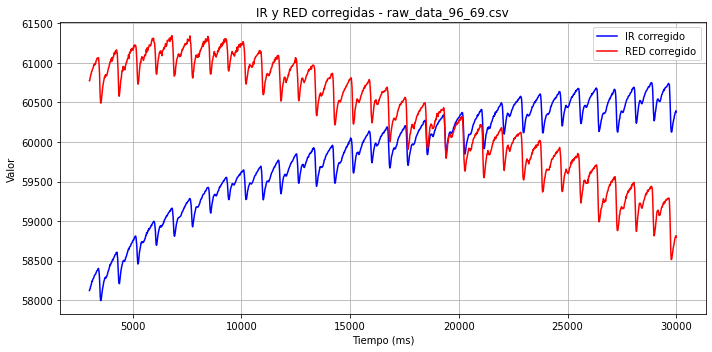

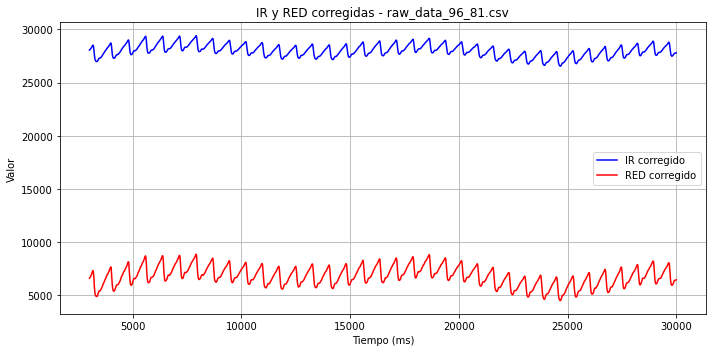

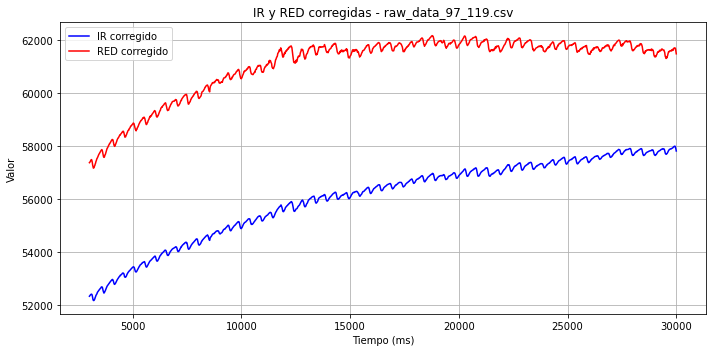

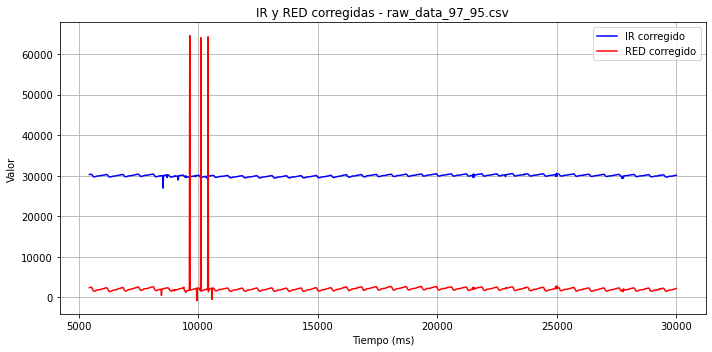

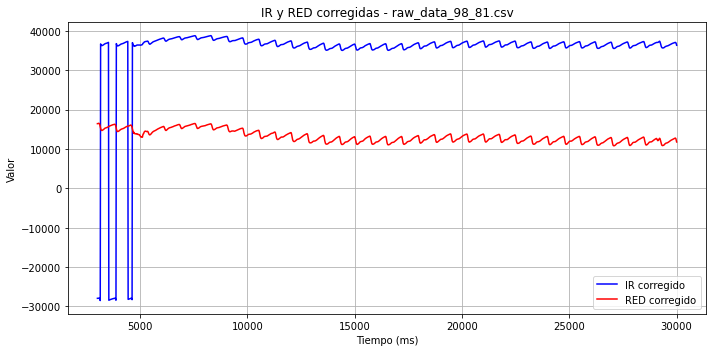

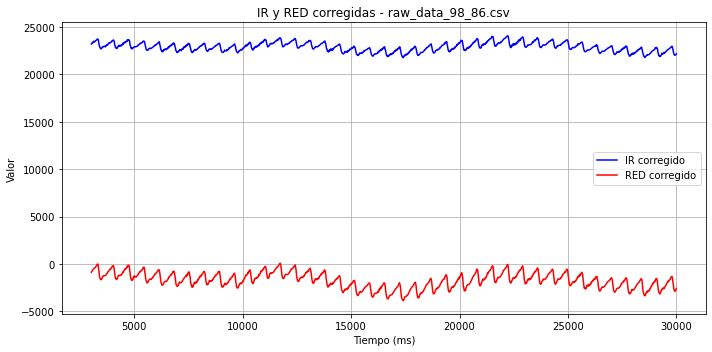

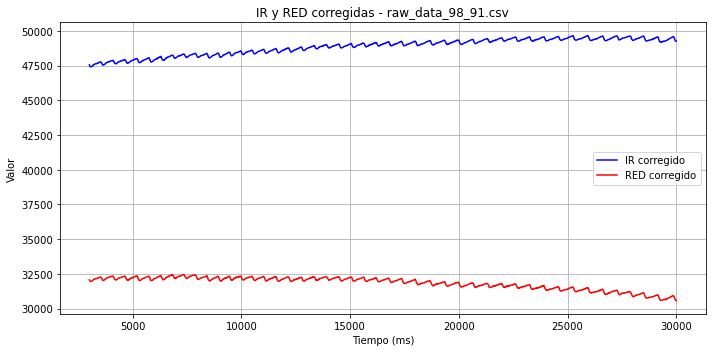

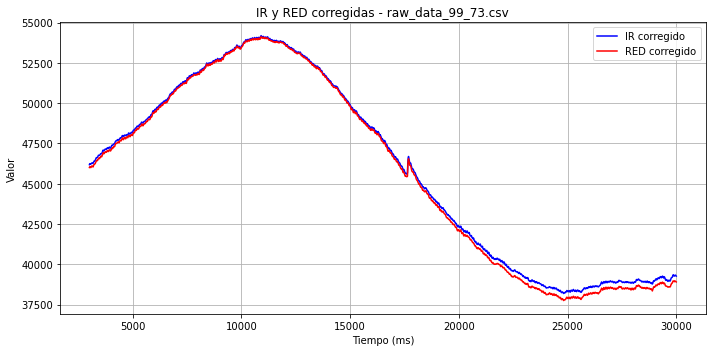

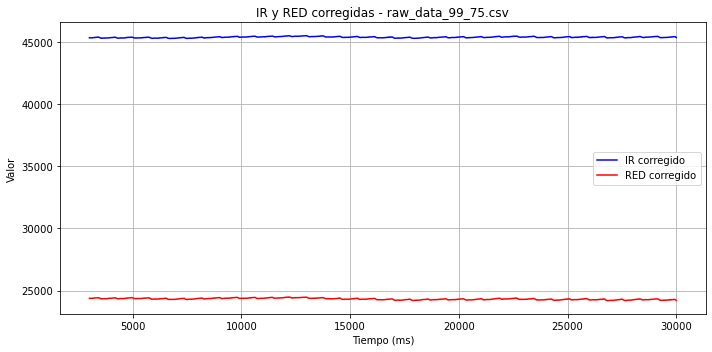

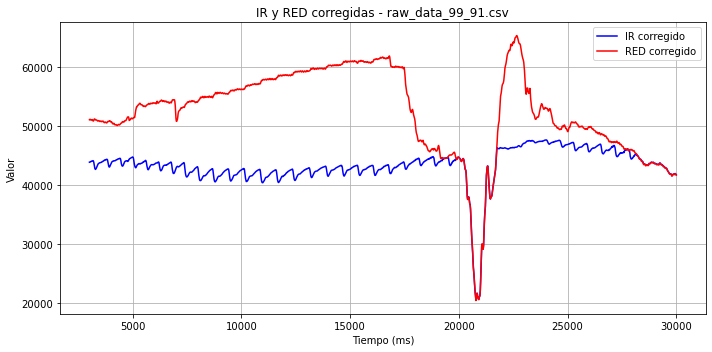

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ruta de los CSVs
ruta_base = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Guardar imágenes o solo mostrar
guardar_png = False
carpeta_salida = os.path.join(ruta_base, "graficas_IR_RED")
if guardar_png and not os.path.exists(carpeta_salida):
    os.makedirs(carpeta_salida)

# Recorrer todos los archivos CSV
for archivo in os.listdir(ruta_base):
    if archivo.endswith(".csv") and archivo.startswith("raw_data"):
        ruta_csv = os.path.join(ruta_base, archivo)
        df = pd.read_csv(ruta_csv)

        # Filtrar primeros 3 segundos
        df_filtrado = df[df["Tiempo (ms)"] >= 3000]

        # Señales corregidas
        ir_corr = df_filtrado["IR"] - df_filtrado["AMB_IR"]
        red_corr = df_filtrado["RED"] - df_filtrado["AMB_RED"]
        tiempo = df_filtrado["Tiempo (ms)"]

        # Crear la gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(tiempo, ir_corr, label="IR corregido", color='blue')
        plt.plot(tiempo, red_corr, label="RED corregido", color='red')
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Valor")
        plt.title(f"IR y RED corregidas - {archivo}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if guardar_png:
            nombre_salida = os.path.splitext(archivo)[0] + "_IR_RED_corr.png"
            plt.savefig(os.path.join(carpeta_salida, nombre_salida))
        else:
            plt.show()

        plt.close()


# Version filtrada y optimizada

## filtro IIR (filtro paso bajo simple)
Este filtro suaviza los cambios bruscos (ruido de alta frecuencia) sin distorsionar la forma general. En nuestro caso:

α = 0.1 (puedes ajustarlo)

Es un filtro muy eficiente, ideal para microcontroladores.

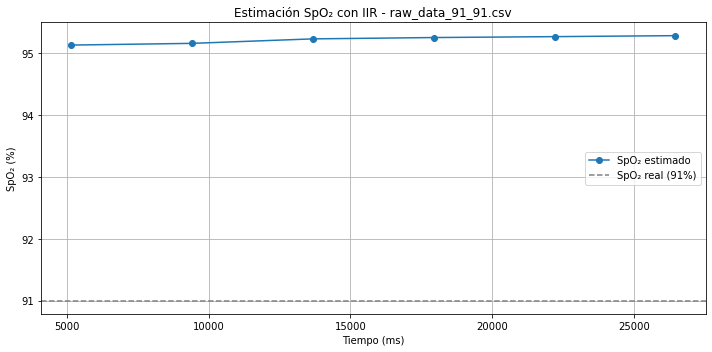

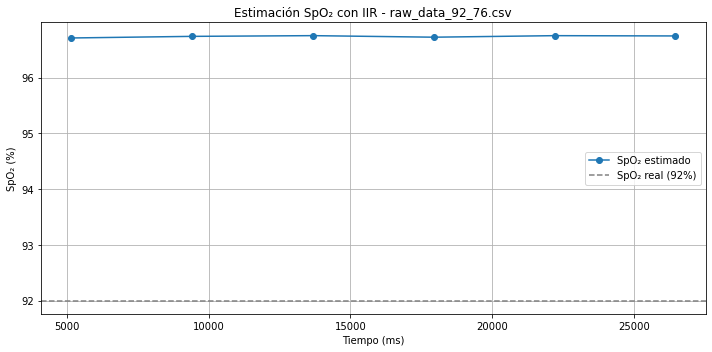

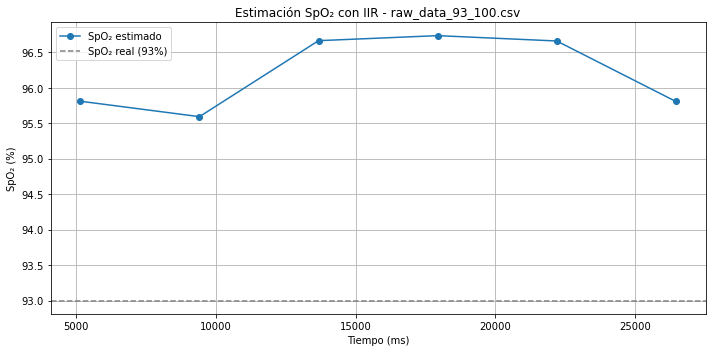

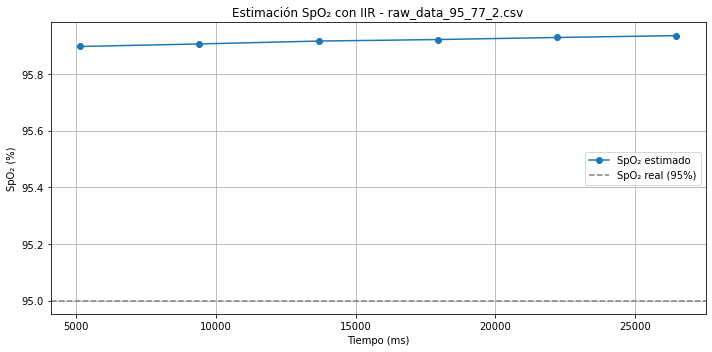

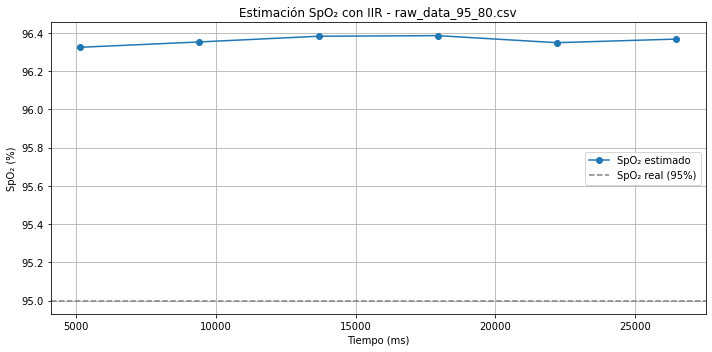

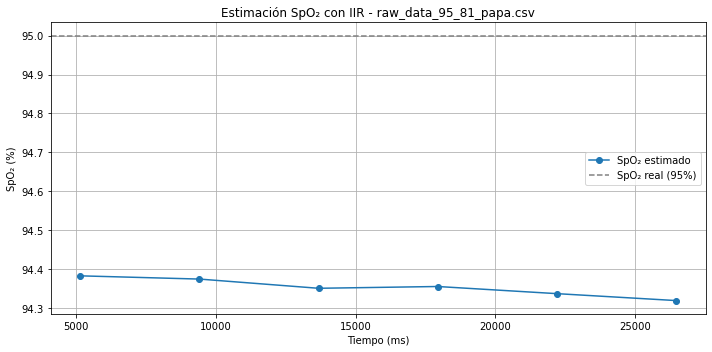

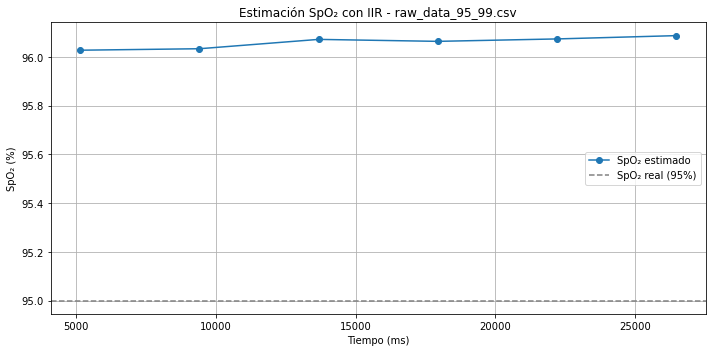

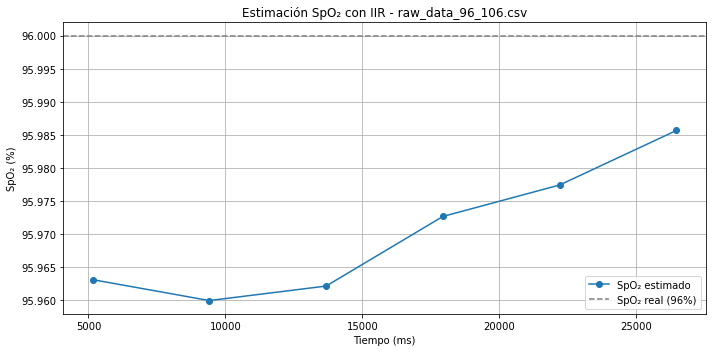

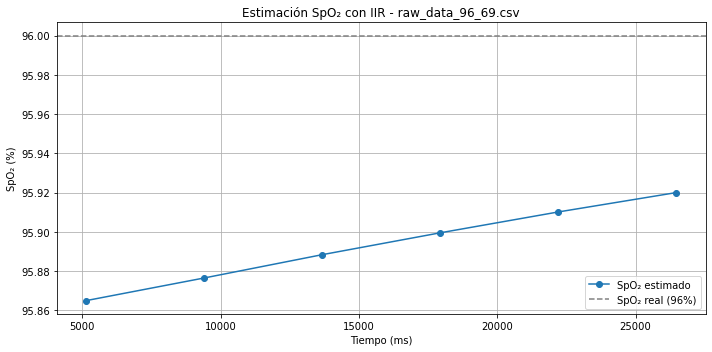

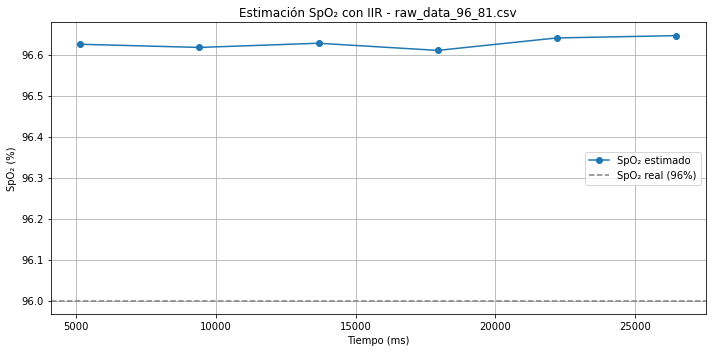

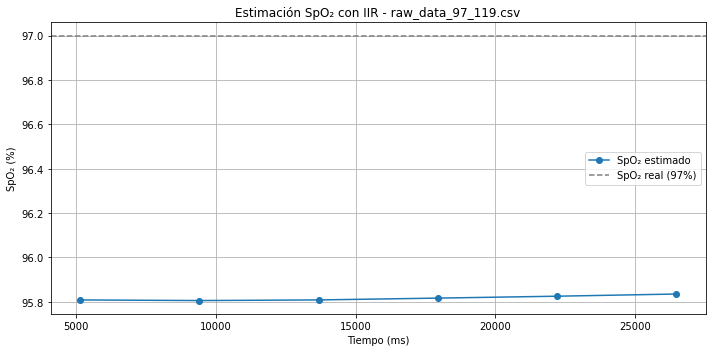

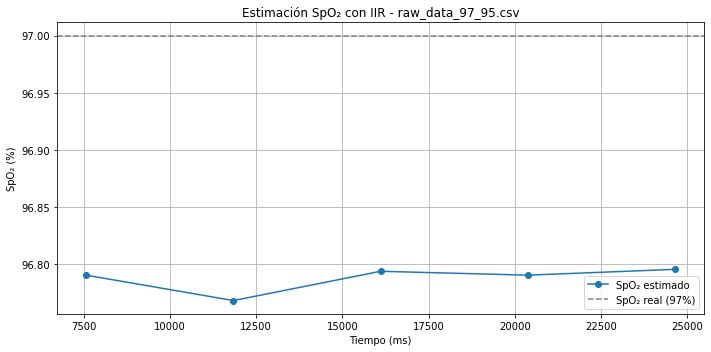

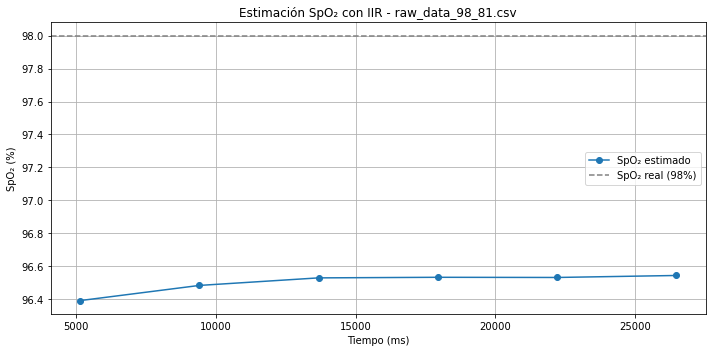

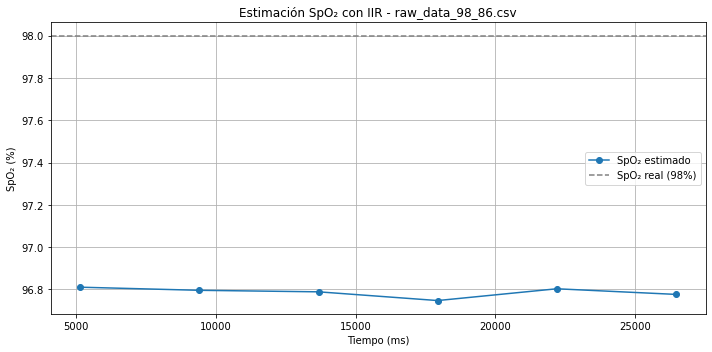

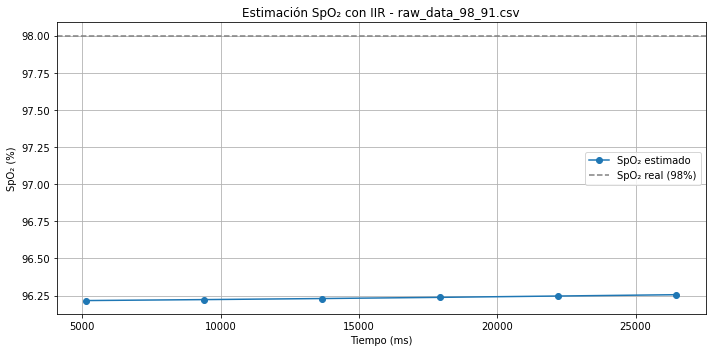

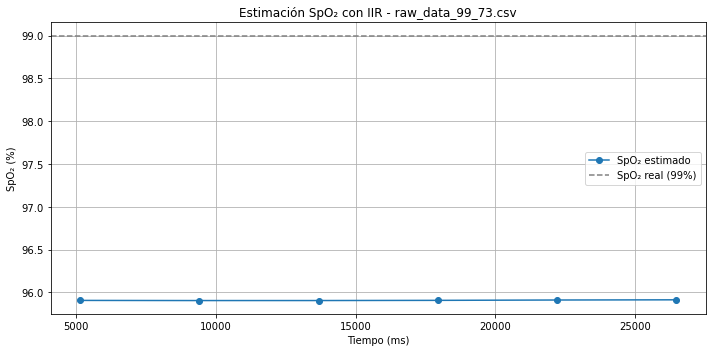

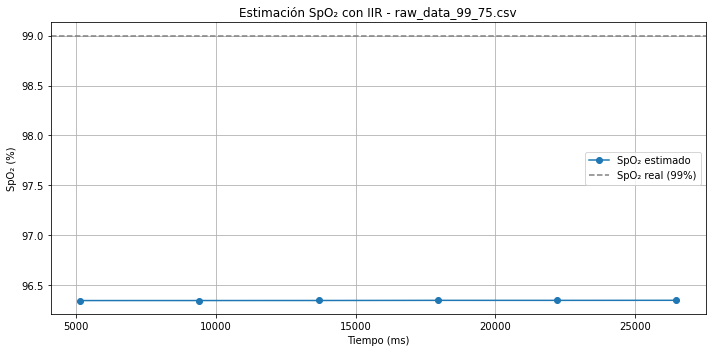

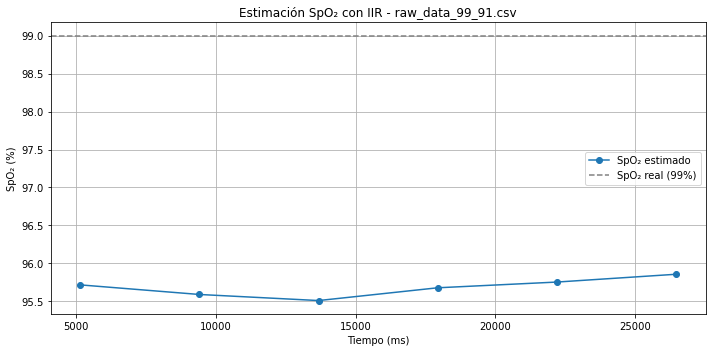

,Archivo,SpO2_real,SpO2_estimado_medio,Error_medio (%)
0,raw_data_91_91.csv,91.0,95.22,4.22
1,raw_data_92_76.csv,92.0,96.74,4.74
2,raw_data_93_100.csv,93.0,96.21,3.21
3,raw_data_95_77_2.csv,95.0,95.92,0.92
4,raw_data_95_80.csv,95.0,96.36,1.36
5,raw_data_95_81_papa.csv,95.0,94.35,-0.65
6,raw_data_95_99.csv,95.0,96.06,1.06
7,raw_data_96_106.csv,96.0,95.97,-0.03
8,raw_data_96_69.csv,96.0,95.89,-0.11
9,raw_data_96_81.csv,96.0,96.63,0.63


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Parámetros
ALPHA = 0.1
WINDOW_SIZE = 256
ruta_base = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Función filtro IIR
def aplicar_filtro_iir(signal, alpha=ALPHA):
    filtrada = np.zeros_like(signal)
    filtrada[0] = signal.iloc[0]
    for i in range(1, len(signal)):
        filtrada[i] = alpha * signal.iloc[i] + (1 - alpha) * filtrada[i - 1]
    return filtrada

# Lista de resultados globales
resultados = []

# Procesar todos los CSVs
for archivo in os.listdir(ruta_base):
    if archivo.startswith("raw_data") and archivo.endswith(".csv"):
        ruta = os.path.join(ruta_base, archivo)

        # Extraer SpO2 real desde el nombre del archivo
        match = re.match(r"raw_data_(\d+)_\d+", archivo)
        if not match:
            continue
        spo2_real = int(match.group(1))

        # Cargar datos
        df = pd.read_csv(ruta)
        df = df[df["Tiempo (ms)"] >= 3000].reset_index(drop=True)

        # Corregir señales
        ir_corr = df["IR"] - df["AMB_IR"]
        red_corr = df["RED"] - df["AMB_RED"]

        # Filtrar
        ir_filt = aplicar_filtro_iir(ir_corr)
        red_filt = aplicar_filtro_iir(red_corr)

        # Procesar por ventanas
        spo2_estimadas = []
        tiempos = []

        for i in range(0, len(ir_filt) - WINDOW_SIZE + 1, WINDOW_SIZE):
            ir_win = ir_filt[i:i+WINDOW_SIZE]
            red_win = red_filt[i:i+WINDOW_SIZE]
            tiempo_central = df["Tiempo (ms)"].iloc[i + WINDOW_SIZE // 2]

            rms_ir = np.sqrt(np.mean(np.square(ir_win)))
            rms_red = np.sqrt(np.mean(np.square(red_win)))

            if rms_ir != 0:
                ratio = rms_red / rms_ir
                spo2_est = -0.9561 * ratio + 96.86

                resultados.append({
                    "Archivo": archivo,
                    "Tiempo (ms)": tiempo_central,
                    "SpO2_real": spo2_real,
                    "SpO2_estimada": spo2_est,
                    "Ratio": ratio
                })

                spo2_estimadas.append(spo2_est)
                tiempos.append(tiempo_central)

        # Mostrar gráfico por archivo
        plt.figure(figsize=(10, 5))
        plt.plot(tiempos, spo2_estimadas, marker='o', label="SpO₂ estimado")
        plt.axhline(y=spo2_real, color='gray', linestyle='--', label=f"SpO₂ real ({spo2_real}%)")
        plt.title(f"Estimación SpO₂ con IIR - {archivo}")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("SpO₂ (%)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Crear DataFrame de resultados globales
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla de errores por archivo
errores_por_archivo = df_resultados.groupby("Archivo").apply(
    lambda g: pd.Series({
        "SpO2_real": g["SpO2_real"].iloc[0],
        "SpO2_estimado_medio": g["SpO2_estimada"].mean(),
        "Error_medio (%)": (g["SpO2_estimada"].mean() - g["SpO2_real"].iloc[0])
    })
).reset_index()

display(errores_por_archivo)

# (Opcional) Guardar en Excel
df_resultados.to_excel("SpO2_estimaciones_filtradas.xlsx", index=False)


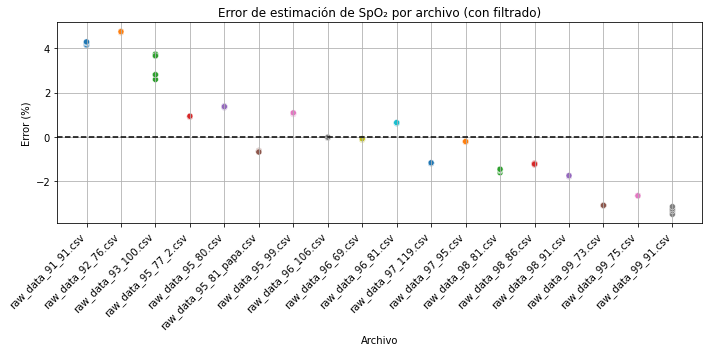

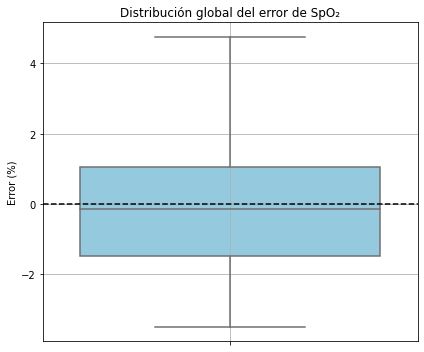

Resumen del error global:


count    107.00
mean       0.03
std        2.27
min       -3.49
25%       -1.47
50%       -0.14
75%        1.07
max        4.75
Name: Error (%), dtype: float64

In [13]:
import seaborn as sns

# Calcular columna de error en el DataFrame completo
df_resultados["Error (%)"] = df_resultados["SpO2_estimada"] - df_resultados["SpO2_real"]

# ────────────── GRÁFICO DE DISPERSIÓN ────────────── #
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_resultados, x="Archivo", y="Error (%)", hue="Archivo", palette="tab10", legend=False)
plt.axhline(y=0, color='black', linestyle='--', label='Sin error')
plt.title("Error de estimación de SpO₂ por archivo (con filtrado)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Error (%)")
plt.xlabel("Archivo")
plt.grid(True)
plt.tight_layout()
plt.show()

# ────────────── BOXPLOT GLOBAL ────────────── #
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_resultados, y="Error (%)", color='skyblue')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Distribución global del error de SpO₂")
plt.ylabel("Error (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resumen estadístico
print("Resumen del error global:")
display(df_resultados["Error (%)"].describe())
